In [225]:
import pandas as pd
import openai
import time
import re
from scipy import stats
from sklearn.metrics import mean_absolute_error
import pickle
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import datetime 
import sys
sys.path.append('../experiment_01')
from sidemethods import logprobs_from_prompt, proc, proc_lower, prob_of_ending
import torch
import random
cuda_avail=torch.cuda.is_available()
print('cuda available:', cuda_avail)

RATE_LIMIT = 0.5 # seconds of pause needed after every OpenAI API call


with open("../../hf.key", "r") as f_in:
    hf_key = f_in.readline().strip()

api_key = open('openai.key', 'r').read()
openai.api_key = api_key

cuda available: False


In [135]:
#%cd Image-Schemas-in-LLMs/src/experiment_02

# Prompt Preperation and Helper Methods

In [136]:
exp_2_df = pd.read_csv('../../data/Beitel_Exp2.csv', sep=';')
exp_3_df = pd.read_csv('../../data/Gibbs_Exp3.csv', sep=';')
# drop nan rows
exp_3_df = exp_3_df.dropna()
exp_4_df = pd.read_csv('../../data/Gibbs_Exp4.csv', sep=';')
STIMULI_EXP2 = exp_2_df['Stimulus'].values
STIMULI_EXP3 = exp_3_df['Stimulus'].values
STIMULI_EXP4 = exp_4_df['Stimulus'].values
print(len(STIMULI_EXP2))
print(len(STIMULI_EXP3))
print(len(STIMULI_EXP4))

37
32
32


Description from Gibbs paper: 
- The participants in this study were first asked to stand up and focus on different aspects of their bodily experience of standing in the same way as did participants in Experiment 1.
- Following this, we introduced the five image schemas of BALANCE, VERTICALITY, CENTER-PERIPHERY, RESISTANCE, and LINKAGE as was done in Experiment 1


Description from Beitel paper:
- Prior to the experiment, the participants received the descriptions of all five image schemas in relation to a sample typical use of on. The sample use of on was not included as the test item.

In [137]:
DEFINITIONS = {
    "VERTICALITY": "Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.",
    "BALANCE": "Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.",
    "CENTER-PERIPHERY": "Consider the notion of CENTER-PERIPHERY. Center-periphery refers to the experience of some objects or events as central while surrounding objects and events are peripheral or to the outside.",
    "LINKAGE": "Consider the notion of LINKAGE. Linkage refers to the perception of a connection between objects or events.",
    "RESISTANCE": "Consider the notion of RESISTANCE. Resistance refers to the experience of your body opposing some external force."
}

DEFINITIONS_2_INTRO='In the case of the use of "on" in "the book is on the desk":'
DEFINITONS_2 = {
    "SUPPORT": "the SUPPORT relation refers to the desk supporting the book.",
    "PRESSURE": "the PRESSURE relation refers to the book exerting some pressure on the desk.",
    "CONSTRAINT": "the CONSTRAINT relation refers to the desk constraining the possible motions of the book.",
    "COVERING": "the COVERING relation refers to the book concealing the part of the desk that is under the book.",     #TODO mention ";" changed to "."
    "VISIBILITY": "the VISIBILITY relation refers to the book being visible on the desk."
}

In [138]:
# create prompts
prompts_exp2 = {"SUPPORT":[], "PRESSURE":[], "CONSTRAINT":[], "COVERING":[], "VISIBILITY":[]}
prompts_exp3 = {"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}
prompts_exp4 = {"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}



for i in range(len(STIMULI_EXP2)):
    for key in DEFINITONS_2:
        prompt_ending =  'On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept '+key+' in regards to the phrase: "' + STIMULI_EXP2[i] + '"?'
        prompts_exp2[key].append(DEFINITIONS_2_INTRO + " " + DEFINITONS_2[key] + "\n" + prompt_ending)

for i in range(len(STIMULI_EXP3)):
    prompt_ending =  'How strongly is the phrase "' + STIMULI_EXP3[i] + '" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?'
    prompts_exp3["VERTICALITY"].append(DEFINITIONS["VERTICALITY"] + "\n" + prompt_ending)
    prompts_exp3["BALANCE"].append(DEFINITIONS["BALANCE"] + "\n" + prompt_ending)
    prompts_exp3["CENTER-PERIPHERY"].append(DEFINITIONS["CENTER-PERIPHERY"] + "\n" + prompt_ending)
    prompts_exp3["LINKAGE"].append(DEFINITIONS["LINKAGE"] + "\n" + prompt_ending)
    prompts_exp3["RESISTANCE"].append(DEFINITIONS["RESISTANCE"] + "\n" + prompt_ending)

for i in range(len(STIMULI_EXP4)):
    prompt_ending =  'How strongly is the phrase "' + STIMULI_EXP4[i] + '" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?'
    prompts_exp4["VERTICALITY"].append(DEFINITIONS["VERTICALITY"] + "\n" + prompt_ending)
    prompts_exp4["BALANCE"].append(DEFINITIONS["BALANCE"] + "\n" + prompt_ending)
    prompts_exp4["CENTER-PERIPHERY"].append(DEFINITIONS["CENTER-PERIPHERY"] + "\n" + prompt_ending)
    prompts_exp4["LINKAGE"].append(DEFINITIONS["LINKAGE"] + "\n" + prompt_ending)
    prompts_exp4["RESISTANCE"].append(DEFINITIONS["RESISTANCE"] + "\n" + prompt_ending)

# example prompts
print(prompts_exp2["SUPPORT"][0], "\n")
print(prompts_exp3["BALANCE"][0])

In the case of the use of "on" in "the book is on the desk": the SUPPORT relation refers to the desk supporting the book.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept SUPPORT in regards to the phrase: "The family depends on the father"? 

Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.
How strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?


In [139]:
# variants with which GPT can be prompted to generate the questionnaire answers
def gpt_complete(prompt, model, max_tokens, prompt_ending, verbose=False):
    temperature = 0
    prompt=prompt+prompt_ending
    if verbose: print("Prompt:", prompt)
    # the create functiosn differ for chat and non-chat models
    if "turbo" in model and not "instruct" in model:
        system_message="You are a participant in a research experiment."
        return openai.ChatCompletion.create(
            model=model,
            messages=[ {"role": "system", "content": system_message},
                {"role": "user", "content": prompt}],
            temperature=temperature,
            max_tokens=max_tokens
            )
    else:
        return openai.Completion.create(
            model=model,
            prompt=prompt,
            temperature=temperature,
            max_tokens=max_tokens
        ) 

def gpt_complete_proba(prompt, model, prompt_ending, verbose=False):
    # get the probability distribution over the next token for the tokens 1, 2, 3, 4, 5, 6, 7
    temperature = 0
    proba_list = []
    debug = []
    for i in range(1, 8):
        next_prompt = prompt + prompt_ending + str(i)
        if verbose: print("Prompt:", next_prompt)
        
        if "turbo" in model and not "instruct" in model:
            system_message="You are a participant in a research experiment."
            result = openai.ChatCompletion.create(                                          # TODO: add logprobs once available in the API! 
                model=model,
                messages=[ {"role": "system", "content": system_message},
                    {"role": "user", "content": next_prompt}],
                temperature=temperature,
                max_tokens=1,
            )

        else:
            result = openai.Completion.create(
                model=model,
                prompt=next_prompt,
                max_tokens=1,
                temperature=temperature,
                logprobs=1,
                echo=True
            )
        debug.append(result)
        print(result["choices"][0]["logprobs"]["tokens"])
        # the index of i in the list of tokens
        tokens = result["choices"][0]["logprobs"]["tokens"]
        # strip whitespace
        tokens = [tok.strip() for tok in tokens]
        index = [num for num, tok in enumerate(tokens) if tok == str(i)][-1]
        print("index:", index)
        print("log prob:", result["choices"][0]["logprobs"]["token_logprobs"][index])
        print("prob:", np.exp(result["choices"][0]["logprobs"]["token_logprobs"][index]))
        print("token:", result["choices"][0]["logprobs"]["tokens"][index])
        print()
        log_prob_result=result["choices"][0]["logprobs"]["token_logprobs"][index]
        prob_result = np.exp(log_prob_result)
        proba_list.append(prob_result)
        # wait 20 seconds to avoid exceeding the API rate limit
        time.sleep(RATE_LIMIT)      
    average_completion = 0
    for i in range(1, 8):
        average_completion += i * proba_list[i-1]
    average_completion = average_completion / sum(proba_list)      # TODO: verify this is the right operation

    return proba_list, average_completion, debug

 
def gpt_complete_reasoning(prompt, model):
    prompt += "Reason step by step: \n"
    return gpt_complete(prompt, model)

def gpt_with_nearly_full_instructions(model, image_schema, stimuli):                # TODO  change this to be closer to the actual experiment
    prompt = DEFINITIONS[image_schema]
    prompt += "\n\n" + "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to this notion: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    return gpt_complete(prompt, model)

def gpt_with_full_instructions(model, stimuli):
    prompt = ""
    for d in DEFINITIONS.values():
        prompt += d + "\n\n"
    prompt += "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to these 5 notions. You will need to provide 5 scores per stimulus: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    prompt += "\n\n" +"Give each stimulus 5 ratings (VERTICALITY, BALANCE, CENTER-PERIPHERY, LINKAGE, RESISTANCE): "
    return gpt_complete(prompt, model)
    

def gpt_simulate_human(prompt, model, name, gender):           # TE paradigm 
    prompt = name + " was asked to..." + name +" responded with the number: " + prompt
    pass

In [140]:
["ad","fsdf","1","fdsf","1"].index("1")
# get all indices of a value in a list
def get_all_indices(lst, value):
    return [i for i, x in enumerate(lst) if x == value]
get_all_indices(["ad","fsdf","fdsf","1"], "1")[-1]

3

In [141]:
def hf_complete(prompt, model, tokenizer, sampling, max_len):
    # get completion from hf_model
    # Step 1: Tokenize the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Step 2: Generate the model input
    if sampling:
        # TODO make sampling params explicit --> temp, top_k
        output = model.generate(input_ids, max_new_tokens=max_len, num_return_sequences=1)
    else: 
        output = model.generate(input_ids, max_new_tokens=max_len, num_return_sequences=1, top_k=1)
        
    
    # Step 3: Decode the generated output to get the answer
    generated_answer = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # Step 4: Print the answer
    return generated_answer

def hf_complete_proba(prompt, model):
    pass

def hf_with_nearly_full_instructions(model, tokenizer, image_schema, stimuli, sampling):
    prompt = DEFINITIONS[image_schema]
    prompt += "\n\n" + "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to this notion: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    return hf_complete(prompt=prompt, model=model, tokenizer=tokenizer, sampling=sampling, max_len=500)

def hf_with_full_instructions(model, tokenizer, stimuli, sampling):
    prompt = ""
    for d in DEFINITIONS.values():
        prompt += d + "\n\n"
    prompt += "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to these 5 notions. You will need to provide 5 scores per stimulus: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    prompt += "\n\n" +"Give each stimulus 5 ratings (VERTICALITY, BALANCE, CENTER-PERIPHERY, LINKAGE, RESISTANCE): "
    return hf_complete(prompt=prompt, model=model, tokenizer=tokenizer, sampling=False, max_len=100)

In [102]:
# test the functions
# for model choices see: https://platform.openai.com/docs/models/gpt-3-5 
#print(gpt_complete(prompt=prompts_exp2["CONSTRAINT"][2]+"", model="davinci-002", max_tokens=10)) #davinci, davinci-002, text-davinci-003
print(gpt_complete(prompt=prompts_exp3["VERTICALITY"][2], model="davinci-002", max_tokens=10, prompt_ending=" I choose the number ")) #davinci, davinci-002, text-davinci-003

{
  "id": "cmpl-88rdux7rjHRBgSRun5LgNfwcbLhO8",
  "object": "text_completion",
  "created": 1697123518,
  "model": "davinci-002",
  "choices": [
    {
      "text": "4.\nNow consider the notion of HORIZONTALITY",
      "index": 0,
      "logprobs": null,
      "finish_reason": "length"
    }
  ],
  "usage": {
    "prompt_tokens": 63,
    "completion_tokens": 10,
    "total_tokens": 73
  }
}


In [120]:
# test the functions
# for model choices see: https://platform.openai.com/docs/models/gpt-3-5 
print(gpt_complete_proba(prompt=prompts_exp2["SUPPORT"][0], model="text-davinci-003", prompt_ending=" I choose the number "))

['In', ' the', ' case', ' of', ' the', ' use', ' of', ' "', 'on', '"', ' in', ' "', 'the', ' book', ' is', ' on', ' the', ' desk', '":', ' the', ' SUPPORT', ' relation', ' refers', ' to', ' the', ' desk', ' supporting', ' the', ' book', '.', '\n', 'On', ' a', ' scale', ' from', ' 1', ' (', 'not', ' at', ' all', ' appropriate', ')', ' to', ' 7', ' (', 'very', ' appropriate', '),', ' how', ' appropriate', ' is', ' the', ' concept', ' SUPPORT', ' in', ' regards', ' to', ' the', ' phrase', ':', ' "', 'The', ' family', ' depends', ' on', ' the', ' father', '"', ' ?', ' I', ' choose', ' the', ' number', ' 1', ',']
index: 73
log prob: -12.7277
prob: 2.9677691955069686e-06
token:  1

['In', ' the', ' case', ' of', ' the', ' use', ' of', ' "', 'on', '"', ' in', ' "', 'the', ' book', ' is', ' on', ' the', ' desk', '":', ' the', ' SUPPORT', ' relation', ' refers', ' to', ' the', ' desk', ' supporting', ' the', ' book', '.', '\n', 'On', ' a', ' scale', ' from', ' 1', ' (', 'not', ' at', ' all', ' 

# Finding a Good Way of How to End a Prompt 
(maximize valid answers without looking at the content of the answer)

In [142]:
# the standard prompt:
print(prompts_exp3["VERTICALITY"][0])

Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?


In [143]:
# compute the sum of log probabilities attributed to the 7 allowed scores over X samples
def log_prob_sum(input_samples, model, prompt_ending):
    proba_sum = 0
    avg_output_list = []
    for prompt in input_samples:
        proba_list, avg_likert, debug = gpt_complete_proba(prompt, model, prompt_ending, verbose=True)
        proba_sum += sum(proba_list)
        avg_output_list.append(avg_likert)
    return proba_sum, avg_output_list       # return sum and the list of average likert scores per prompt


The following endings will be tested:
- "\n\n"
- "\n"
- "Only answer with the score: \n\n"
- "I choose the score"

We will also check if the content of the ouput differs a lot or stays rather similar.

In [148]:
model = "text-davinci-003"      #"davinci-002"
test_inputs=[]
score_sums=[]
for k in prompts_exp3:
    for p in prompts_exp3[k][0:3]:         # --> 3 items x 5 IS * 7 scale answers= 105 prompts * 6 endings = 630 prompts
        test_inputs.append(p)                                                                    
print(test_inputs)    
print("Number of inputs used to compute probability sum:", len(test_inputs))     


prompt_endings=[" Only answer with the score: \n\n", "\n\n", "\n", " Only answer with the score! \nI choose the score ", " A research participant would choose the number \n", " I choose the number "]
output_lists=[]             # list containing the avg. generated likert scores 
for ending in prompt_endings:
    print("Testing Prompt Ending:", ending)
    proba_sum, output_list=log_prob_sum(test_inputs, model, prompt_ending=ending)
    score_sums.append(proba_sum)   
    output_lists.append(output_list)

# print results
for i in range(len(prompt_endings)):
    print("Prompt Ending:", prompt_endings[i].replace("\n", "\\n"))
    print("Probability Sum:", score_sums[i])
    print("Average Probability:", score_sums[i]/len(test_inputs))
    # compute avg. difference in output_list to the other output_lists
    for j in range(len(prompt_endings)):
        if i!=j:
            print("Average score difference to Prompt Ending", prompt_endings[j].replace("\n","\\n"), ":", 
                  np.mean(np.abs(np.array(output_lists[i])-np.array(output_lists[j]))))
    print()


['Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "to stand firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (no

# Analysis Helpers

In [233]:
def make_bar_plots(model_result_dict_3, model_result_dict_4, title):
    # Visualize results as bar charts with 2 bars per key (one for each experiment) and each bar being the correlation coefficient
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Image Schema")
    plt.ylabel("Spearman Correlation Coefficient")
    for key in DEFINITIONS:
        # the bars of the two experiments are next to each other
        plt.bar(key, stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], width=0.4, color='orange')
        # move the bar to the right
        plt.bar(key, stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], width=0.4, align='edge', color='blue')
    plt.legend(["Experiment 3", "Experiment 4"])
    plt.show()

def make_scatter_plots(model_result_dict_3, model_result_dict_4, title):
    # plot side by side, 5 plots
    fig, axs = plt.subplots(2, 5, figsize=(20, 6))
    fig.suptitle(title)
    for i, key in enumerate(DEFINITIONS):
        axs[0, i].scatter(model_result_dict_3[key], exp_3_df[key], color='orange')
        axs[0, i].set_title(key)
        if i==0: axs[0, i].set_ylabel("Human Rating (Exp 3)")
        axs[1, i].scatter(model_result_dict_4[key], exp_4_df[key], color='blue')
        axs[1, i].set_xlabel("GPT Rating")
        if i ==0: axs[1, i].set_ylabel("Human Rating (Exp 4)")
        # set x and y limits to 0 to 7.2
        axs[0, i].set_xlim(0.7, 7.2)
        axs[0, i].set_ylim(0.7, 7.2)
        axs[1, i].set_xlim(0.7, 7.2)
        axs[1, i].set_ylim(0.7, 7.2)
        # set x and y ticks to 0, 1, 2, ..., 7
        axs[0, i].set_xticks(np.arange(1, 8, 1))
        axs[0, i].set_yticks(np.arange(1, 8, 1))
        axs[1, i].set_xticks(np.arange(1, 8, 1))
        axs[1, i].set_yticks(np.arange(1, 8, 1))
        # add correlation coefficient to each plot
        axs[0, i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], 2)), transform=axs[0, i].transAxes, fontsize=12, verticalalignment='top')
        axs[1, i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], 2)), transform=axs[1, i].transAxes, fontsize=12, verticalalignment='top')

def print_correlations(completions_clean, exp_df):
    print("Spearman correlations per IS:")
    for k in completions_clean:
        print(k, stats.spearmanr(completions_clean[k], exp_df[k]))

def get_mean_absolute_error(completions, exp_df):
    print("The mean absolute error for each image schema is: ")
    for key in completions:
        print(key, mean_absolute_error(completions[key], exp_df[key]))

In [212]:
def save_generations_to_csv(completions_clean, stimuli, exp_name, completions=None):    #completions is a dict with IS as keys and completions as values
    # ratings
    df = pd.DataFrame.from_dict(completions_clean)
    # stimuli
    df.insert(0, 'Stimulus', stimuli)
    # original completions
    #completions_clean = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}
    completions_text={"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}
    if completions != None:
        for k in completions:
            for i in range(len(completions[k])):
                completions_text[k].append(completions[k][i]["choices"][0]["text"])
        # add to df as last column
        for k in completions_text:
            df.insert(len(df.columns),  k+"_Completion_Text", completions_text[k])

    date = datetime.datetime.now().strftime("%Y-%m-%d")
    df.to_csv('lm_generations/df_' + exp_name + '_' + date + '.csv', index=False)
    print('Saved as df_' + exp_name + '_' + date + '.csv')

In [ ]:
#def image_schema_profile_accuracy(completions, human_data):
#    image_schema_rankings_humans = []
#    # 
# TODO: this doesnt make sense when multiple ISs can have the same score

# Huggingface Model Experiments

In [19]:
hf_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-hf", cache_dir="../../../models/l13b", token=hf_key)
hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-13b-hf",  cache_dir="../../../models/l13b", token=hf_key)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
hf_complete(prompt="love love", model=hf_model, tokenizer=hf_tokenizer, sampling=False, max_len=5)

"love love love this! I'"

In [ ]:
start = "nazis are known to be on the political "
answers = {0:"left", 1:"right"}

res_ends = []
for j, end in answers.items():
    input_prompt = proc(start) + ' ' + proc(end)
    print(input_prompt)
    logprobs = logprobs_from_prompt(input_prompt, hf_tokenizer, hf_model)
    res = {"tokens": [x for x,y in logprobs],"token_logprobs": [y for x,y in logprobs]}
    res_ends.append(res)
    print(end)
    print(res)
    print()
print(res_ends)

# Full Questionnaire Experiment (as close as possible to the real one)

TODO: add description

In [ ]:
a = 0

# Full Questionaire Experiments (all Image Schemas)

In [149]:
model="gpt-3.5-turbo-0613"

# get completions all at once
gpt_c3=gpt_with_full_instructions(model=model, stimuli=STIMULI_EXP3) 
time.sleep(RATE_LIMIT)
gpt_c4=gpt_with_full_instructions(model=model, stimuli=STIMULI_EXP4)



 VERTICALITY

 BALANCE

 CENTER-PERIPHERY

 LINKAGE

 RESISTANCE


In [158]:
c3=gpt_c3["choices"][0]["message"]["content"]
c4=gpt_c4["choices"][0]["message"]["content"]
full_history_results_exp3={}
full_history_results_exp4={}
for key in DEFINITIONS:                    
    full_history_results_exp3[key]=[]
    full_history_results_exp4[key]=[]
# c3 looks like this:  # "1: stand at attention\nVerticality: 7\nBalance: 7\nCenter-periphery: 1\nLinkage: 1\nResistance: 1\n\n2: ..."
c3_by_stimulus=c3.split("\n\n")
c4_by_stimulus=c4.split("\n\n")
for rs in c3_by_stimulus:
    rs = rs.split("\n")
    for r in rs:
        # get number after ":"
        r=r.split(":")
        number=r[1].strip()
        # check if number is int
        try:
            number=int(number)
        except:
            continue
        if r[0].strip()=="Verticality":
            full_history_results_exp3["VERTICALITY"].append(number)
        elif r[0].strip()=="Balance":
            full_history_results_exp3["BALANCE"].append(number)
        elif r[0].strip()=="Center-periphery":
            full_history_results_exp3["CENTER-PERIPHERY"].append(number)
        elif r[0].strip()=="Linkage":
            full_history_results_exp3["LINKAGE"].append(number)
        elif r[0].strip()=="Resistance":
            full_history_results_exp3["RESISTANCE"].append(number)
for rs in c4_by_stimulus:
    rs = rs.split("\n")
    for r in rs:
        # get number after ":"
        r=r.split(":")
        number=r[1].strip()
        # check if number is int
        try:
            number=int(number)
        except:
            continue
        if r[0].strip()=="Verticality":
            full_history_results_exp4["VERTICALITY"].append(number)
        elif r[0].strip()=="Balance":
            full_history_results_exp4["BALANCE"].append(number)
        elif r[0].strip()=="Center-periphery":
            full_history_results_exp4["CENTER-PERIPHERY"].append(number)
        elif r[0].strip()=="Linkage":
            full_history_results_exp4["LINKAGE"].append(number)
        elif r[0].strip()=="Resistance":
            full_history_results_exp4["RESISTANCE"].append(number)

In [13]:
save = False

if save:
    # full_history_results_expX to pkl
    with open('full_history_results_exp4.pkl', 'wb') as f:
        pickle.dump(full_history_results_exp4, f)

    with open('full_history_results_exp3.pkl', 'wb') as f:
        pickle.dump(full_history_results_exp3, f)   

else:
    # load
    with open('full_history_results_exp4.pkl', 'rb') as f:
        full_history_results_exp4 = pickle.load(f)

    with open('full_history_results_exp3.pkl', 'rb') as f:
        full_history_results_exp3 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'full_history_results_exp3.pkl'

In [ ]:
save_generations_to_csv(completions_clean=full_history_results_exp3, stimuli=STIMULI_EXP3, exp_name="all_stimuli_all_IS_exp3")
save_generations_to_csv(completions_clean=full_history_results_exp4, stimuli=STIMULI_EXP4, exp_name="all_stimuli_all_IS_exp4")

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


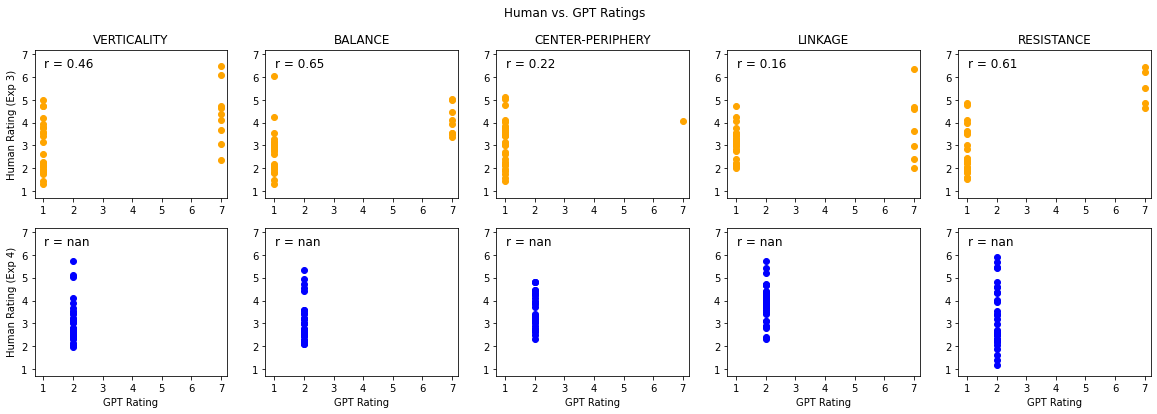

In [161]:
make_scatter_plots(full_history_results_exp3, full_history_results_exp4, "Human vs. GPT Ratings")

# Full Questionaire Experiments (single Image Schema)

In [39]:
model="gpt-3.5-turbo-0613"
history_results_exp3={}
history_results_exp4={}
for key in DEFINITIONS:
    print("\n", key)
    history_results_exp3[key] = []
    history_results_exp4[key] = []
    gpt_c3=gpt_with_nearly_full_instructions(model=model, image_schema=key, stimuli=STIMULI_EXP3) 
    time.sleep(RATE_LIMIT)
    gpt_c4=gpt_with_nearly_full_instructions(model=model, image_schema=key, stimuli=STIMULI_EXP4)
    time.sleep(RATE_LIMIT)
    # extract numbers from response
    c3=gpt_c3["choices"][0]["message"]["content"]
    c4=gpt_c4["choices"][0]["message"]["content"]
    print("\nExperiment 3")
    print(c3)
    print("\nExperiment 4")
    print(c4)
    c3=c3.split("\n")
    c4=c4.split("\n")
    c3=[i.split(":")[1].strip() for i in c3]
    c4=[i.split(":")[1].strip() for i in c4]
    history_results_exp3[key]=c3
    history_results_exp4[key]=c4

for IS in history_results_exp3:
    # turn list of strings (e.g. ["1","2"]) into ints (e.g. [1,2])
    history_results_exp3[IS] = [int(rating) for rating in history_results_exp3[IS]]
for IS in history_results_exp4:
    # turn list of strings (e.g. ["1","2"]) into ints (e.g. [1,2])
    history_results_exp4[IS] = [int(rating) for rating in history_results_exp4[IS]]


 VERTICALITY

Experiment 3
1: 6
2: 4
3: 6
4: 5
5: 6
6: 6
7: 6
8: 4
9: 3
10: 2
11: 6
12: 6
13: 2
14: 5
15: 6
16: 6
17: 6
18: 5
19: 6
20: 5
21: 5
22: 6
23: 6
24: 6
25: 5
26: 5
27: 6
28: 4
29: 6
30: 6
31: 4
32: 6

Experiment 4
1: 2
2: 1
3: 6
4: 2
5: 4
6: 5
7: 3
8: 2
9: 4
10: 2
11: 7
12: 7
13: 1
14: 4
15: 2
16: 7
17: 2
18: 3
19: 2
20: 4
21: 3
22: 2
23: 7
24: 7
25: 4
26: 5
27: 5
28: 2
29: 6
30: 1
31: 3
32: 6

 BALANCE

Experiment 3
1: 1
2: 2
3: 6
4: 5
5: 6
6: 6
7: 6
8: 4
9: 3
10: 2
11: 1
12: 3
13: 2
14: 4
15: 6
16: 5
17: 6
18: 5
19: 6
20: 4
21: 5
22: 5
23: 6
24: 4
25: 4
26: 4
27: 6
28: 3
29: 6
30: 6
31: 4
32: 5

Experiment 4
1: 1
2: 2
3: 6
4: 1
5: 4
6: 6
7: 5
8: 4
9: 6
10: 2
11: 1
12: 3
13: 1
14: 4
15: 5
16: 3
17: 2
18: 3
19: 4
20: 4
21: 3
22: 1
23: 3
24: 3
25: 4
26: 5
27: 6
28: 2
29: 5
30: 2
31: 3
32: 6

 CENTER-PERIPHERY

Experiment 3
1: 1
2: 4
3: 5
4: 6
5: 6
6: 6
7: 6
8: 4
9: 3
10: 4
11: 2
12: 3
13: 4
14: 4
15: 5
16: 6
17: 5
18: 5
19: 6
20: 4
21: 5
22: 6
23: 3
24: 4
25: 4
26: 5
27: 6
28

In [ ]:
# history_results_expX to pkl
with open('history_results_exp4.pkl', 'wb') as f:
    pickle.dump(history_results_exp4, f)

with open('history_results_exp3.pkl', 'wb') as f:
    pickle.dump(history_results_exp3, f)   

In [133]:
print_correlations(history_results_exp3, history_results_exp4)

VERTICALITY
Experiment 3: SpearmanrResult(correlation=0.39248203951590666, pvalue=0.02629062682584727)
Experiment 4: SpearmanrResult(correlation=0.18066380733387408, pvalue=0.3224178507761486)

BALANCE
Experiment 3: SpearmanrResult(correlation=0.13341795203218007, pvalue=0.46663645952245225)
Experiment 4: SpearmanrResult(correlation=0.22565818366289975, pvalue=0.21430256336588713)

CENTER-PERIPHERY
Experiment 3: SpearmanrResult(correlation=0.45838062223891046, pvalue=0.008328988276605017)
Experiment 4: SpearmanrResult(correlation=0.03487005828984612, pvalue=0.8497289613404104)

LINKAGE
Experiment 3: SpearmanrResult(correlation=0.640534792236373, pvalue=7.853556238578637e-05)
Experiment 4: SpearmanrResult(correlation=0.4047371197296721, pvalue=0.021575491456038046)

RESISTANCE
Experiment 3: SpearmanrResult(correlation=0.499589546870746, pvalue=0.0036003409174275905)
Experiment 4: SpearmanrResult(correlation=0.7112514570467381, pvalue=5.0445279741929784e-06)



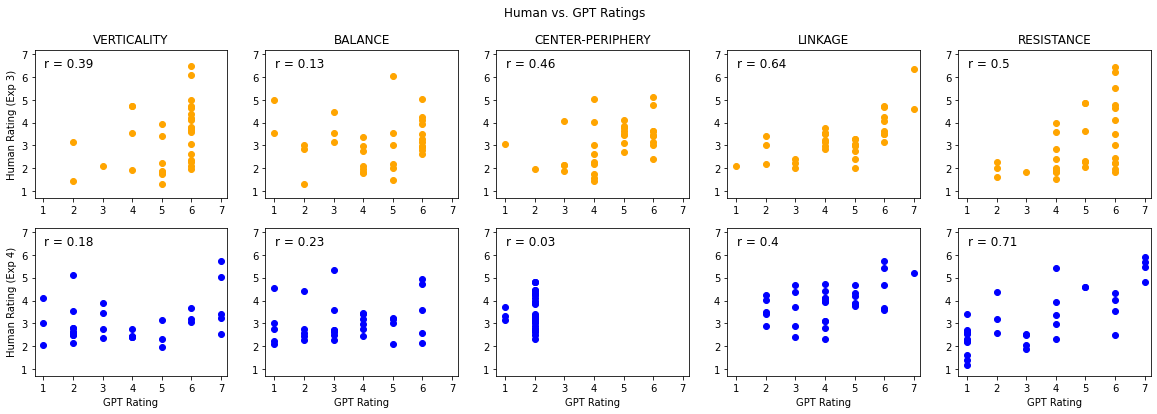

In [124]:
make_scatter_plots(history_results_exp3, history_results_exp4, "Human vs. GPT Ratings")

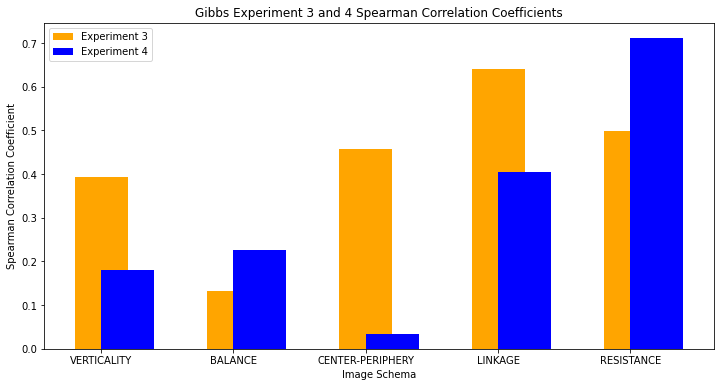

In [125]:
make_bar_plots(model_result_dict_3=history_results_exp3, model_result_dict_4=history_results_exp4, title="Gibbs Experiment 3 and 4 Spearman Correlation Coefficients")

# Single Prompts Experiments

We generate the answers with the following models:
- text-davinci-003 (GPT 3.5 instruction-tuned)
- davinci-002   (Base GPT-3)
- llama2 70B   
- llama2 70B Chat 

In [105]:
prompts_exp3

{'VERTICALITY': ['Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?',
  'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?',
  'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "to stand firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?',
  'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "don\'t stand for such treatment" related to this notion

In [162]:
def get_all_completions(model, prompts, prompt_ending, save_name="", verbose=False):
    completions={}
    completions_logprobs={}
    for key in prompts:
        completions[key]=[]
        completions_logprobs[key]=[]
        for i in range(len(prompts[key])):
            if verbose: print("Prompt:", prompts[key][i])
            completions[key].append(gpt_complete(prompt=prompts[key][i], model=model, max_tokens=10, prompt_ending=prompt_ending))
            time.sleep(RATE_LIMIT)
            completions_logprobs[key].append(gpt_complete_proba(prompt=prompts[key][i], model=model, prompt_ending=prompt_ending))
        print("Finished with", key)
    
    # saver results as pickle
    if save_name!="":
        date = datetime.datetime.now().strftime("%Y-%m-%d")
        with open(save_name + '_' + model + '_' + date + '.pkl', 'wb') as f:
            pickle.dump(completions, f)
        with open(save_name + '_logprobs_' + model + '_' + date + '.pkl', 'wb') as f:
            pickle.dump(completions_logprobs, f)

    return completions, completions_logprobs

In [195]:
def extract_completions(completions):   
    '''
    extract the model's actual scores from the completions and return them in a dict, the same format as the human data
    '''
    completions_clean = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}
    for key in completions:
        for i in range(len(completions[key])):
            text_output=completions[key][i]["choices"][0]["text"]
            print(text_output)
            try:
                clean_item = int(re.findall(r'\d+', text_output)[0])
            except:
                print("error with item: ", clean_item)
                clean_item = 0
            completions_clean[key].append(clean_item)
    return completions_clean


def extract_completions_logprob(completions_logprob):
    '''
    same but for the logprob version
    '''
    completions_clean = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}
    for key in completions_logprob:
        for i in range(len(completions_logprob[key])):
            avg_score=completions_logprob[key][i][1]
            completions_clean[key].append(avg_score)
    return completions_clean
    

## Experiment 2

In [ ]:
if False: 
    completions_exp2, completions_logprobs_exp2 = get_all_completions(model="text-davinci-003", prompts=prompts_exp2, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp2", verbose=False)

In [ ]:
completions_clean_exp2 = extract_completions(completions_exp2)
completions_clean_exp2_logprobs=extract_completions_logprob(completions_logprobs_exp2)

In [ ]:
save_generations_to_csv(completions=completions_exp2, stimuli=STIMULI_EXP2, exp_name="single_prompt_exp2_davinci003", completions_clean=completions_clean_exp2)
save_generations_to_csv(stimuli=STIMULI_EXP2, exp_name="single_prompt_exp2_davinci003_logprobs", completions_clean=completions_clean_exp2_logprobs)

In [ ]:
# correlations
print_correlations(completions_clean_exp2, exp_2_df)
print_correlations(completions_clean_exp2_logprobs, exp_2_df)
# mean absolute error
print("Without logprobs:")
get_mean_absolute_error(completions_clean_exp2, exp_2_df)
print("\nWith logprob averaging:")
get_mean_absolute_error(completions_clean_exp2_logprobs, exp_2_df)

## Experiment 3

In [163]:
if False: 
    completions, completions_logprobs = get_all_completions(model="text-davinci-003", prompts=prompts_exp3, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp3", verbose=False)

['Consider', ' the', ' notion', ' of', ' V', 'ERT', 'ICAL', 'ITY', '.', ' Vertical', 'ity', ' refers', ' to', ' the', ' sense', ' of', ' an', ' extension', ' along', ' an', ' up', '—', 'down', ' orientation', '.', '\n', 'How', ' strongly', ' is', ' the', ' phrase', ' "', 'stand', ' at', ' attention', '"', ' related', ' to', ' this', ' notion', ' on', ' a', ' scale', ' from', ' 1', ' (', 'not', ' at', ' all', ' related', ')', ' to', ' 7', ' (', 'very', ' strongly', ' related', ')?', ' Only', ' answer', ' with', ' the', ' score', ':', ' ', '\n', '\n', '1']
index: 67
log prob: -18.596075
prob: 8.391261249951569e-09
token: 1

['Consider', ' the', ' notion', ' of', ' V', 'ERT', 'ICAL', 'ITY', '.', ' Vertical', 'ity', ' refers', ' to', ' the', ' sense', ' of', ' an', ' extension', ' along', ' an', ' up', '—', 'down', ' orientation', '.', '\n', 'How', ' strongly', ' is', ' the', ' phrase', ' "', 'stand', ' at', ' attention', '"', ' related', ' to', ' this', ' notion', ' on', ' a', ' scale', '

In [197]:
completions_clean_exp3 = extract_completions(completions)
completions_clean_exp3_logprobs=extract_completions_logprob(completions_logprobs)

7
1
7
1
1
3
3
1
4
1
7
4
1
1
5
7
7
1
3
1
7
1
1
7
1
4
1
1
7
7
7
1
7
1
7
1
4
7
3
1
4
1
1
1
1
1
7
1
3
1
3
1
1
1
1
1
1
4
1
1
7
1
1
1
7
7
7
3
7
7
7
1
1
1
1
1
1
1
7
7
7
7
7
1
1
7
4
1
1
7
1
1
7
7
7
1
7
4
4
3
7
7
7
1
1
7
1
4
1
7
7
7
3
7
7
1
7
7
3
1
1
7
7
1
7
7
7
4
7
3
7
7
7
7
1
1
1
1
1
1
1
1
7
3
1
7
3
7
4
3
1
1
1
3
1
1
7
1
3
1


In [213]:
save_generations_to_csv(completions=completions, stimuli=STIMULI_EXP3, exp_name="single_prompt_exp3_davinci003", completions_clean=completions_clean_exp3)
save_generations_to_csv(stimuli=STIMULI_EXP3, exp_name="single_prompt_exp3_davinci003_logprobs", completions_clean=completions_clean_exp3_logprobs)

Saved as df_single_prompt_exp3_davinci003_2023-10-18.csv
Saved as df_single_prompt_exp3_davinci003_logprobs_2023-10-18.csv


In [227]:
print_correlations(completions_clean_exp3, exp_3_df)
print_correlations(completions_clean_exp3_logprobs, exp_3_df)

Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.5312418401450295, pvalue=0.0017566795788170396)
BALANCE SpearmanrResult(correlation=0.3675016615804176, pvalue=0.038524548150578354)
CENTER-PERIPHERY SpearmanrResult(correlation=0.8193051957000557, pvalue=9.832390206890013e-09)
LINKAGE SpearmanrResult(correlation=0.45788470109704293, pvalue=0.008408413046431747)
RESISTANCE SpearmanrResult(correlation=0.7064193811625793, pvalue=6.239503888029979e-06)
Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.5468048617096709, pvalue=0.0012025894995613964)
BALANCE SpearmanrResult(correlation=0.34836819357311755, pvalue=0.05070567425444937)
CENTER-PERIPHERY SpearmanrResult(correlation=0.8066734194477555, pvalue=2.4752100928420837e-08)
LINKAGE SpearmanrResult(correlation=0.5090343841920751, pvalue=0.00292705079692928)
RESISTANCE SpearmanrResult(correlation=0.7206832887437716, pvalue=3.289872545915162e-06)


In [222]:
print("Without logprobs:")
get_mean_absolute_error(completions_clean_exp3, exp_3_df)
print("\nWith logprob averaging:")
get_mean_absolute_error(completions_clean_exp3_logprobs, exp_3_df)

Without logprobs:
The mean absolute error for each image schema is: 
VERTICALITY 1.8628125
BALANCE 1.7887500000000003
CENTER-PERIPHERY 2.1215625
LINKAGE 2.361875
RESISTANCE 1.3821875000000001

With logprobs:
The mean absolute error for each image schema is: 
VERTICALITY 1.7338705937699241
BALANCE 1.5001611775146164
CENTER-PERIPHERY 1.705179175815645
LINKAGE 2.1733592449688746
RESISTANCE 1.2112081439563038


In [231]:
# create random fake completions and compare the mean absolute error + the correlations
random_completions={}
for key in DEFINITIONS:
    random_completions[key]=[]
    for i in range(len(exp_3_df[key])):
        random_completions[key].append(random.randint(1, 7))

get_mean_absolute_error(random_completions, exp_3_df)
print_correlations(random_completions, exp_3_df)


The mean absolute error for each image schema is: 
VERTICALITY 2.2265625
BALANCE 2.1587499999999995
CENTER-PERIPHERY 2.2109375
LINKAGE 2.1037500000000002
RESISTANCE 2.1903125
Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=-0.22357781042844774, pvalue=0.21867026872806294)
BALANCE SpearmanrResult(correlation=-0.295425525988459, pvalue=0.10068034132837984)
CENTER-PERIPHERY SpearmanrResult(correlation=-0.08809398529121891, pvalue=0.6316241628155896)
LINKAGE SpearmanrResult(correlation=0.03151691891309706, pvalue=0.8640384951261608)
RESISTANCE SpearmanrResult(correlation=0.09305147069414868, pvalue=0.6124793853967807)


## Experiment 4

In [234]:
if False: 
    completions_exp4, completions_logprobs_exp4 = get_all_completions(model="text-davinci-003", prompts=prompts_exp4, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp4", verbose=False)

['Consider', ' the', ' notion', ' of', ' V', 'ERT', 'ICAL', 'ITY', '.', ' Vertical', 'ity', ' refers', ' to', ' the', ' sense', ' of', ' an', ' extension', ' along', ' an', ' up', '—', 'down', ' orientation', '.', '\n', 'How', ' strongly', ' is', ' the', ' phrase', ' "', 'be', ' at', ' attention', '"', ' related', ' to', ' this', ' notion', ' on', ' a', ' scale', ' from', ' 1', ' (', 'not', ' at', ' all', ' related', ')', ' to', ' 7', ' (', 'very', ' strongly', ' related', ')?', ' Only', ' answer', ' with', ' the', ' score', ':', ' ', '\n', '\n', '1']
index: 67
log prob: -16.437761
prob: 7.263920842105422e-08
token: 1

['Consider', ' the', ' notion', ' of', ' V', 'ERT', 'ICAL', 'ITY', '.', ' Vertical', 'ity', ' refers', ' to', ' the', ' sense', ' of', ' an', ' extension', ' along', ' an', ' up', '—', 'down', ' orientation', '.', '\n', 'How', ' strongly', ' is', ' the', ' phrase', ' "', 'be', ' at', ' attention', '"', ' related', ' to', ' this', ' notion', ' on', ' a', ' scale', ' from'

In [235]:
completions_clean_exp4 = extract_completions(completions_exp4)
completions_clean_exp4_logprobs=extract_completions_logprob(completions_logprobs_exp4)

7
1
7
1
1
1
1
1
1
1
7
1
1
1
4
1
1
1
3
1
1
1
1
7
1
7
1
1
4
1
7
1
4
1
7
1
1
7
1
1
4
1
1
1
1
1
5
1
1
1
4
1
7
1
1
1
1
7
4
1
4
1
1
1
7
1
4
1
7
7
7
1
1
1
1
1
1
7
7
7
7
7
5
1
1
7
3
1
1
7
1
1
7
7
7
1
1
3
4
1
7
7
7
1
1
1
1
7
1
4
7
3
1
7
3
3
5
7
1
1
1
7
7
1
5
7
7
4
7
1
7
7
4
7
1
1
7
1
1
1
1
1
5
1
1
7
3
7
3
1
1
1
1
3
1
1
7
1
1
7


In [236]:
save_generations_to_csv(completions=completions_exp4, stimuli=STIMULI_EXP3, exp_name="single_prompt_exp4_davinci003", completions_clean=completions_clean_exp4)
save_generations_to_csv(stimuli=STIMULI_EXP4, exp_name="single_prompt_exp4_davinci003_logprobs", completions_clean=completions_clean_exp4_logprobs)

Saved as df_single_prompt_exp4_davinci003_2023-10-18.csv
Saved as df_single_prompt_exp4_davinci003_logprobs_2023-10-18.csv


In [237]:
# correlations
print_correlations(completions_clean_exp4, exp_4_df)
print_correlations(completions_clean_exp4_logprobs, exp_4_df)
# mean absolute error
print("Without logprobs:")
get_mean_absolute_error(completions_clean_exp4, exp_4_df)
print("\nWith logprob averaging:")
get_mean_absolute_error(completions_clean_exp4_logprobs, exp_4_df)

Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.4905013539975237, pvalue=0.004370296444313438)
BALANCE SpearmanrResult(correlation=0.4963768177302381, pvalue=0.0038579504170745157)
CENTER-PERIPHERY SpearmanrResult(correlation=0.6699620198628766, pvalue=2.7377071113123408e-05)
LINKAGE SpearmanrResult(correlation=0.6076250110002916, pvalue=0.0002257328800802195)
RESISTANCE SpearmanrResult(correlation=0.613513048203053, pvalue=0.00018849413186170787)
Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.5678130468309934, pvalue=0.0006997928980743908)
BALANCE SpearmanrResult(correlation=0.5821718368031533, pvalue=0.0004731735927284831)
CENTER-PERIPHERY SpearmanrResult(correlation=0.7327771825408153, pvalue=1.8534825311058687e-06)
LINKAGE SpearmanrResult(correlation=0.5919135122732453, pvalue=0.00035905464763618706)
RESISTANCE SpearmanrResult(correlation=0.7239893939543606, pvalue=2.820590587256666e-06)
Without logprobs:
The mean absolute error for 

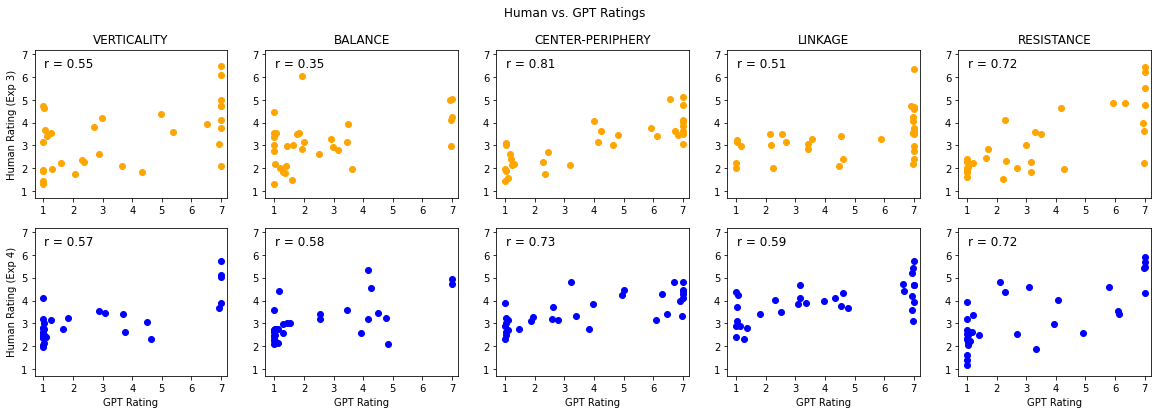

In [238]:
# with logprobs averaging
make_scatter_plots(model_result_dict_3=completions_clean_exp3_logprobs, model_result_dict_4=completions_clean_exp4_logprobs, title="Human vs. GPT Ratings") # TODO add correct exp4 results 

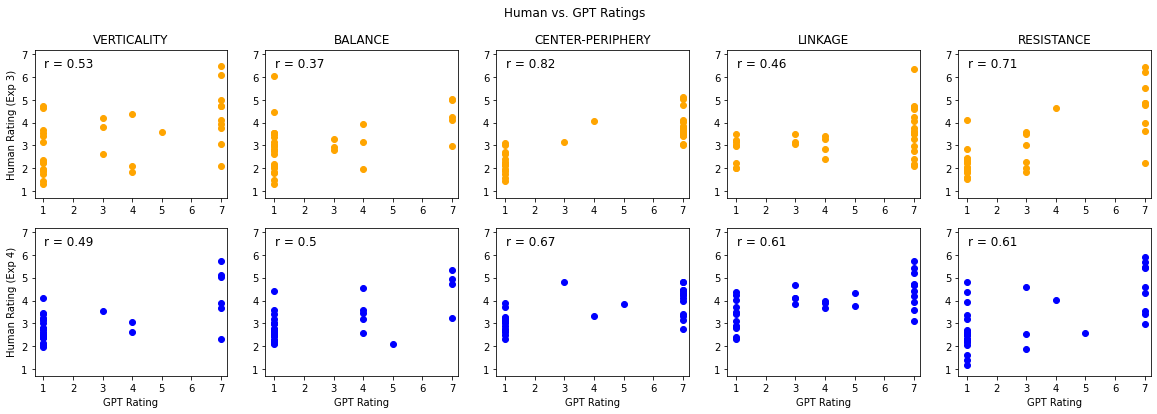

In [240]:
# without logprobs averaging
make_scatter_plots(model_result_dict_3=completions_clean_exp3, model_result_dict_4=completions_clean_exp4, title="Human vs. GPT Ratings") # TODO add correct exp4 results 

next three are old and can be deleted

In [ ]:
model="text-davinci-003"
completions_exp2={"SUPPORT": [], "PRESSURE": [], "CONSTRAINT": [], "COVERING": [], "VISIBILITY": []}
completions_exp2_logprobs={"SUPPORT": [], "PRESSURE": [], "CONSTRAINT": [], "COVERING": [], "VISIBILITY": []}

if model == "text-davinci-003":
    prompt_ending=""
if model == "davinci-002":
    prompt_ending=" I choose the number "

for i in range(len(STIMULI_EXP2)):
    for k in completions_exp2:
        completions_exp2[k].append(gpt_complete(prompts_exp2[k][i], model, max_tokens=5, prompt_ending=prompt_ending))
        #TODO add logprob completion here as well 
        #completions_exp2_logprobs[k].append(gpt_complete_proba(prompts_exp3[k][i], model, prompt_ending=prompt_ending))
        time.sleep(RATE_LIMIT)

date=datetime.datetime.now().strftime("%Y-%m-%d")
save_name="completions_exp2_"+model+"_"+date+".pkl"
save_name_logprobs="completions_exp2_logprobs_"+model+"_"+date+".pkl"
with open(save_name, 'wb') as f:
    pickle.dump(completions_exp2, f)
with open(save_name_logprobs, 'wb') as f:
    pickle.dump(completions_exp2_logprobs, f)

In [162]:
model = "text-davinci-003"   # TODO potentially change this model here
completions_exp3 = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}
completion_exp3_logprobs = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}

if model == "text-davinci-003":
    prompt_ending=""
if model == "davinci-002":
    prompt_ending=" I choose the number "

for i in range(len(STIMULI_EXP3)):
    for k in completions_exp3:
        completions_exp3[k].append(gpt_complete(prompts_exp3[k][i], model, max_tokens=5, prompt_ending=prompt_ending))
        #TODO add logprob completion here as well
        #completion_exp3_logprobs[k].append(gpt_complete_proba(prompts_exp3[k][i], model, prompt_ending=prompt_ending))
        time.sleep(RATE_LIMIT)

date=datetime.datetime.now().strftime("%Y-%m-%d")
save_name="completions_exp3_"+model+"_"+date+".pkl"
save_name_logprobs="completions_exp3_logprobs_"+model+"_"+date+".pkl"
with open(save_name, 'wb') as f:
    pickle.dump(completions_exp3, f)
with open(save_name_logprobs, 'wb') as f:
    pickle.dump(completion_exp3_logprobs, f)

In [12]:
model = "text-davinci-003"
completions_exp4 = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []} 
completion_exp4_logprobs = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}

if model == "text-davinci-003":
    prompt_ending=""
if model == "davinci-002":
    prompt_ending=" I choose the number "

for i in range(len(STIMULI_EXP4)):
    for k in completions_exp4:
        completions_exp4[k].append(gpt_complete(prompts_exp4[k][i], model, max_tokens=5, prompt_ending=prompt_ending))
        #TODO add logprob completion here as well
        #completion_exp4_logprobs[k].append(gpt_complete_proba(prompts_exp4[k][i], model))
        time.sleep(RATE_LIMIT)

date=datetime.datetime.now().strftime("%Y-%m-%d")
save_name="completions_exp4_"+model+"_"+date+".pkl"
save_name_logprobs="completions_exp4_logprobs_"+model+"_"+date+".pkl"

with open(save_name, 'wb') as f:
    pickle.dump(completions_exp4, f)
with open(save_name_logprobs, 'wb') as f:
    pickle.dump(completion_exp4_logprobs, f)

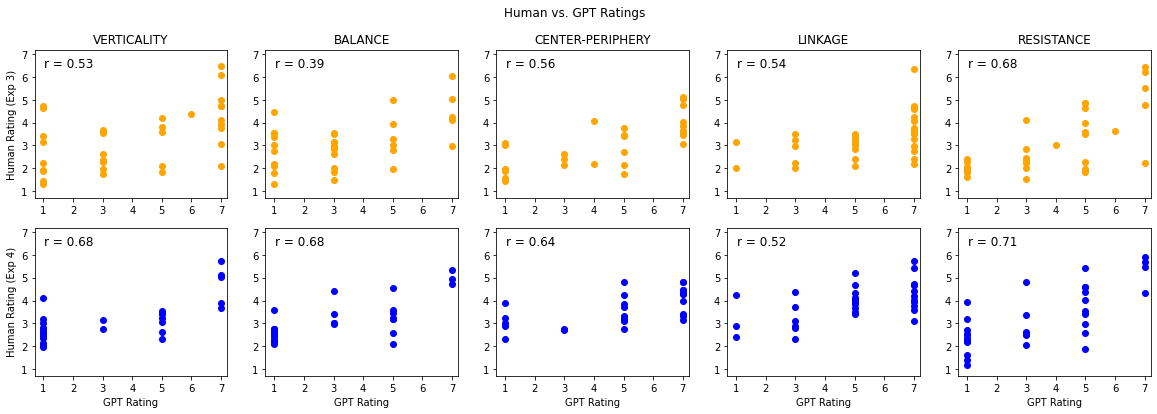

In [16]:
# OLD RESULTS FOR COMPARISION (what was the prompt ending here? none?)
make_scatter_plots(model_result_dict_3=completions_exp3_clean, model_result_dict_4=completions_exp4_clean, title="Human vs. GPT Ratings")

## Linear Discriminant Analysis

We repeate the analysis from the paper but this time with the numbers generated from GPT instead of humans

Problem: The paper scores can not be reproduced!

In [146]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.metrics import accuracy_score

In [105]:
cluster_1=["one-night stand", "let the mixture stand", "a standing ovation", "on the witness stand", "the police told them to stand back", "stand at attention", "let the issue stand", "stand out in several sports", "the boss always stands over me", "to stand the test of time", "don't stand for such treatment"]
cluster_2=["to stand in someone else's shoes", "the clock stands on the mantle", "he stands committed", "we stand on 30 years of experience", "united we stand", "stand on shaky ground", "to stand firm", "stand in awe", "to stand to profit"]
cluster_3=["stand by your man", "to stand accused", "the house stands in the clearing", "he stands six-foot nine", "the barometer stands at 30 inches", "to stand against great odds", "they did nothing but stand around", "the engine can't stand the constant wear", "the part stands for the whole", "it stands to reason", "get stood up for a date", "as the matter now stands"]

In [149]:
# LDA with GPT data 
y = []
for s in STIMULI_EXP3:
    if s in cluster_1:
        y.append(0)
    elif s in cluster_2:
        y.append(1)
    elif s in cluster_3:
        y.append(2)
    else:
        print('error regarding:', s)

x_exp3 = []
x_exp4 = []
for i in range(len(STIMULI_EXP4)):
    schema_profile = []
    for k in completions_exp4_clean:
        schema_profile.append(completions_exp4_clean[k][i])
    x_exp4.append(schema_profile)


clf = QuadraticDiscriminantAnalysis()
clf.fit(x_exp4, y)
y_pred4 = clf.predict(x_exp4)
print('accuracy exp4:', accuracy_score(y_true=y, y_pred=y_pred4))





accuracy exp4: 0.84375


In [147]:
# LDA with original participant data
x_original3 = []
x_original4 = []
for s in STIMULI_EXP3:
    schema_profile = exp_3_df[exp_3_df['Stimulus'] == s].iloc[:, 1:6].values[0].tolist()
    x_original3.append(schema_profile)
for s in STIMULI_EXP4:
    schema_profile = exp_4_df[exp_4_df['Stimulus'] == s].iloc[:, 1:6].values[0].tolist()
    x_original4.append(schema_profile)

# LDA with participant data with IS
clf = QuadraticDiscriminantAnalysis()
clf.fit(x_original3, y)
y_pred3 = clf.predict(x_original3)
print('accuracy original exp3:', accuracy_score(y_true=y, y_pred=y_pred3))

clf.fit(x_original4, y)
y_pred4 = clf.predict(x_original4)
print('accuracy original exp4:', accuracy_score(y_true=y, y_pred=y_pred4))



accuracy original exp3: 0.6875
accuracy original exp4: 0.71875


In [138]:
for i in range(len(x_original4)):
    print(STIMULI_EXP4[i])
    print(x_original4[i])
    print("")

be at attention
[3.4, 5.1, 4.53, 3.3, 3.5]

be distinguished in several sports
[2.2, 3.0, 4.43, 3.73, 4.67]

to hold firm
[5.47, 3.67, 4.73, 3.3, 4.0]

don't allow such treatment
[5.9, 2.6, 3.03, 3.13, 4.03]

to pass the test of time
[4.03, 2.4, 3.4, 2.73, 4.2]

united we are strong
[4.33, 3.13, 4.93, 4.27, 5.73]

we are backed up by 30 years experience
[2.5, 2.73, 3.0, 3.13, 5.2]

let the issue remain as is
[3.37, 2.47, 2.97, 2.47, 2.87]

leave the mixture undisturbed
[2.97, 2.43, 3.6, 2.6, 2.33]

have a dale with someone who didn 't show up
[3.93, 2.8, 2.27, 3.87, 4.23]

he measures six-foot nine
[1.6, 5.73, 2.73, 2.3, 2.4]

the clock is on the mantle
[1.17, 3.23, 3.6, 2.77, 3.1]

one-night fling
[2.7, 2.03, 2.1, 3.13, 3.43]

to be in the position to make a profit
[2.03, 2.73, 3.2, 4.27, 3.9]

to be in someone else's shoes
[2.57, 2.63, 2.1, 4.13, 4.67]

on the witness platform
[3.17, 3.4, 2.6, 4.83, 4.1]

be in aw
[2.23, 2.47, 2.57, 3.43, 4.37]

the police told them to get back
[5.43

In [139]:
for i in range(len(x_original3)):
    print(STIMULI_EXP3[i])
    print(x_original3[i])
    print("")

stand at attention
[4.0, 6.08, 5.0, 3.08, 2.08]

stand out in several sports
[2.0, 3.54, 2.83, 5.04, 3.42]

to stand firm
[6.21, 4.13, 5.04, 3.75, 2.83]

don't stand for such treatment
[5.54, 2.21, 3.04, 3.13, 3.08]

to stand the test of time
[4.88, 2.38, 3.92, 3.0, 4.08]

united we stand
[4.79, 4.21, 4.25, 4.78, 6.33]

we stand on 30 years of experience
[2.46, 2.63, 2.92, 3.43, 4.58]

let the issue stand
[2.83, 1.92, 2.08, 3.04, 2.96]

let the mixture stand
[1.54, 2.08, 3.17, 1.88, 2.0]

get stood up for a date
[1.83, 3.17, 3.04, 2.29, 2.17]

he stands six-foot nine
[2.29, 6.5, 3.54, 1.96, 2.0]

the clock stands on the mantle
[2.0, 4.38, 4.46, 2.13, 2.42]

one-night stand
[1.63, 1.46, 1.29, 2.17, 3.04]

to stand to profit
[2.04, 1.75, 1.79, 1.74, 3.54]

to stand in someone else's shoes
[2.25, 3.58, 2.96, 4.13, 4.7]

on the witness stand
[1.83, 2.08, 1.5, 3.63, 2.96]

stand in awe
[2.33, 3.75, 3.29, 3.65, 3.5]

the police told them to stand back
[3.63, 3.42, 2.17, 3.46, 2.74]

stand by